In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


In [118]:
#Need to include this function to get baseline results from original data
def compute_mle_elo(
    df, SCALE=400, BASE=10, INIT_RATING=1000, sample_weight=None
):
    from sklearn.linear_model import LogisticRegression
    ptbl_a_win = pd.pivot_table(
        df[df["winner"] == "model_a"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    # if no tie, create a zero matrix
    if sum(df["winner"].isin(["tie", "tie (bothbad)"])) == 0:
        ptbl_tie = pd.DataFrame(0, index=ptbl_a_win.index, columns=ptbl_a_win.columns)
    else:
        ptbl_tie = pd.pivot_table(
            df[df["winner"].isin(["tie", "tie (bothbad)"])],
            index="model_a",
            columns="model_b",
            aggfunc="size",
            fill_value=0,
        )
        ptbl_tie = ptbl_tie + ptbl_tie.T

    ptbl_b_win = pd.pivot_table(
        df[df["winner"] == "model_b"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    ptbl_win = ptbl_a_win * 2 + ptbl_b_win.T * 2 + ptbl_tie

    models = pd.Series(np.arange(len(ptbl_win.index)), index=ptbl_win.index)

    p = len(models)
    X = np.zeros([p * (p - 1) * 2, p])
    Y = np.zeros(p * (p - 1) * 2)

    cur_row = 0
    sample_weights = []
    for m_a in ptbl_win.index:
        for m_b in ptbl_win.columns:
            if m_a == m_b:
                continue
            # if nan skip
            if math.isnan(ptbl_win.loc[m_a, m_b]) or math.isnan(ptbl_win.loc[m_b, m_a]):
                continue
            X[cur_row, models[m_a]] = +math.log(BASE)
            X[cur_row, models[m_b]] = -math.log(BASE)
            Y[cur_row] = 1.0
            sample_weights.append(ptbl_win.loc[m_a, m_b])

            X[cur_row + 1, models[m_a]] = math.log(BASE)
            X[cur_row + 1, models[m_b]] = -math.log(BASE)
            Y[cur_row + 1] = 0.0
            sample_weights.append(ptbl_win.loc[m_b, m_a])
            cur_row += 2
    X = X[:cur_row]
    Y = Y[:cur_row]

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-6)
    lr.fit(X, Y, sample_weight=sample_weights)
    elo_scores = SCALE * lr.coef_[0] + INIT_RATING
    if "mixtral-8x7b-instruct-v0.1" in models.index:
        elo_scores += 1114 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    ranking = pd.Series(elo_scores, index=models.index).sort_values(ascending=False)
    ranking_df = pd.DataFrame(ranking, columns=['bt_score'])
    ranking_df["rank"] = ranking_df['bt_score'].rank(method='first', ascending=False).astype(int)
    return ranking_df

In [119]:
#Calculate the ranking and score from the real data
battles = pd.read_csv('./data/battles.csv', index_col=0)
real = compute_mle_elo(battles)
real.rename(columns={"rank":"real_rank", "bt_score": "real_score"}, inplace=True)
real

,real_score,real_rank
model_a,,
chatgpt-4o-latest,1315.159610,1
gemini-1.5-pro-exp-0801,1298.427093,2
gpt-4o-2024-05-13,1285.826879,3
gpt-4o-mini-2024-07-18,1274.848774,4
claude-3-5-sonnet-20240620,1270.975339,5
...,...,...
chatglm-6b,878.986381,125
fastchat-t5-3b,868.292863,126
stablelm-tuned-alpha-7b,839.685718,127


In [120]:
#Functions to comute averages of the 1000 trials for each simulation
def get_stats_rank(df, old):
    old = old["real_rank"]
    means = np.mean(df, axis=1)
    stds = np.std(df, axis=1)
    summary = pd.DataFrame({
        "mean_rank" : means, 
        "std" : stds
    })
    summary = pd.concat([summary, old], axis=1)
    summary = summary[["real_rank", "mean_rank", "std"]]
    
    return summary.iloc[:20, :]

def get_stats_score(df, old):
    old = old["real_score"]
    means = np.mean(df, axis=1)
    stds = np.std(df, axis=1)
    summary = pd.DataFrame({
        "mean_score" : means, 
        "std" : stds
    })
    summary = pd.concat([summary, old], axis=1)
    summary = summary[["real_score", "mean_score", "std"]]
    return summary.iloc[:20, :]

def get_stats_rank_bias(df, num):
    means = np.mean(df, axis=1)
    summary = pd.DataFrame({
        f"mean_rank_{num}" : means, 
    })
    return summary.iloc[:20, :]

def get_stats_score_bias(df, num):
    means = np.mean(df, axis=1)
    summary = pd.DataFrame({
        f"mean_score_{num}" : means, 
    })
    return summary.iloc[:20, :]


In [121]:
#Get averaged results from all trials by reading in data and applying stats functions
replay_rank = pd.read_csv('./data/replay_sim_rank.csv', index_col=0)
replay_score = pd.read_csv('./data/replay_sim_score.csv', index_col=0)
bias2_rank = get_stats_rank_bias(pd.read_csv('./data/bias0.02_gpt_rank.csv', index_col=0), "02")
bias4_rank = get_stats_rank_bias(pd.read_csv('./data/bias0.04_gpt_rank.csv', index_col=0), "04")
bias6_rank = get_stats_rank_bias(pd.read_csv('./data/bias0.06_gpt_rank.csv', index_col=0),"06")
bias8_rank = get_stats_rank_bias(pd.read_csv('./data/bias0.08_gpt_rank.csv', index_col=0), "08")
bias10_rank = get_stats_rank_bias(pd.read_csv('./data/bias0.1_gpt_rank.csv', index_col=0), "10")
biases_rank = pd.concat([real["real_rank"], bias2_rank, bias4_rank, bias6_rank, bias8_rank, bias10_rank], axis=1)

bias2_score = get_stats_score_bias(pd.read_csv('./data/bias0.02_gpt_score.csv', index_col=0), "02")
bias4_score = get_stats_score_bias(pd.read_csv('./data/bias0.04_gpt_score.csv', index_col=0), "04")
bias6_score = get_stats_score_bias(pd.read_csv('./data/bias0.06_gpt_score.csv', index_col=0), "06")
bias8_score = get_stats_score_bias(pd.read_csv('./data/bias0.08_gpt_score.csv', index_col=0), "08")
bias10_score = get_stats_score_bias(pd.read_csv('./data/bias0.1_gpt_score.csv', index_col=0), "10")
biases_score = pd.concat([real["real_score"], bias2_score, bias4_score, bias6_score, bias8_score, bias10_score], axis=1)

#Print example
biases_rank.iloc[:10, :]

,real_rank,mean_rank_02,mean_rank_04,mean_rank_06,mean_rank_08,mean_rank_10
chatgpt-4o-latest,1,1.195,2.000,3.067,8.862,13.601
gemini-1.5-pro-exp-0801,2,1.805,1.000,1.000,1.000,1.000
gpt-4o-2024-05-13,3,3.000,3.002,3.358,4.176,6.097
gpt-4o-mini-2024-07-18,4,4.383,5.756,6.820,7.287,8.844
claude-3-5-sonnet-20240620,5,4.718,4.594,4.670,3.109,3.163
gemini-advanced-0514,6,6.546,6.698,6.240,4.934,4.505
llama-3.1-405b-instruct,7,6.360,4.950,2.941,2.005,2.000
gpt-4o-2024-08-06,8,9.173,10.660,12.017,13.165,14.055
gemini-1.5-pro-api-0514,9,8.372,8.235,8.569,8.196,7.910
gemini-1.5-pro-api-0409-preview,10,9.700,9.689,9.999,10.282,9.626


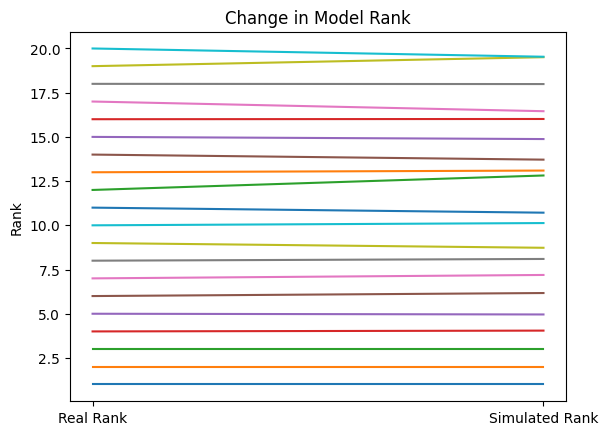

In [125]:
rank_sim = get_stats_rank(replay_rank, real)

fig,ax = plt.subplots(1)

ax.set_title("Change in Model Rank")
ax.set_ylabel("Rank")
ax.plot([rank_sim['real_rank'], rank_sim['mean_rank']])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Real Rank", "Simulated Rank"])

plt.show()

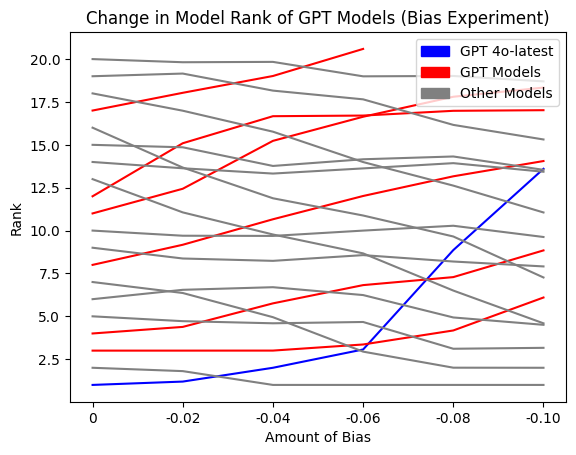

In [126]:
#Visualize Change in model rank at diferents levels of bias removed
import matplotlib.patches as mpatches

fig,ax = plt.subplots(1)
biases_rank = biases_rank.iloc[:20, :]
ax.set_title("Change in Model Rank of GPT Models (Bias Experiment)")
ax.set_ylabel("Rank")
ax.set_xlabel("Amount of Bias")

# Specify the rows to color red
special = biases_rank.reset_index(names="model")
highlight_rows = special["model"].str.contains("gpt")

# Plot each row individually
for i in range(20):
    color = 'blue' if i==0 else 'red' if highlight_rows[i] else 'grey'
    ax.plot(biases_rank.columns, biases_rank.iloc[i], color=color)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(["0", "-0.02", "-0.04", "-0.06", "-0.08", "-0.10"])

# Define custom legend
blue_patch = mpatches.Patch(color='blue', label='GPT 4o-latest')
red_patch = mpatches.Patch(color='red', label='GPT Models')
grey_patch = mpatches.Patch(color='grey', label='Other Models')


# Add legend to plot
plt.legend(handles=[blue_patch, red_patch, grey_patch])

plt.show()

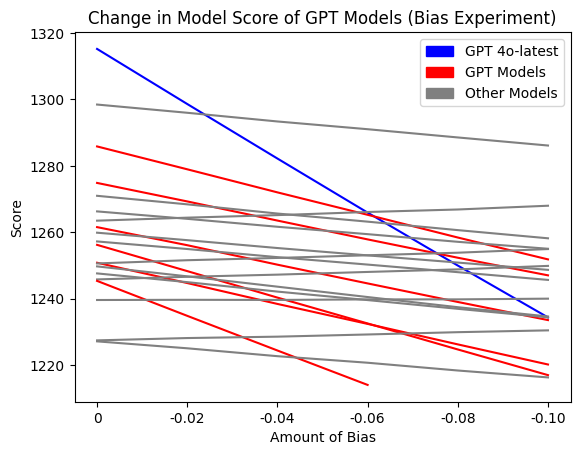

In [127]:
#Visualize change in model score for different levels of bias removed
fig,ax = plt.subplots(1)
biases_rank = biases_rank.iloc[:20, :]
ax.set_title("Change in Model Score of GPT Models (Bias Experiment)")
ax.set_ylabel("Score")
ax.set_xlabel("Amount of Bias")

# Specify the rows to color red
special = biases_score.reset_index(names="model")
highlight_rows = special["model"].str.contains("gpt")

# Plot each row individually
for i in range(20):
    color = 'blue' if i==0 else 'red' if highlight_rows[i] else 'grey'
    ax.plot(biases_score.columns, biases_score.iloc[i], color=color)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(["0", "-0.02", "-0.04", "-0.06", "-0.08", "-0.10"])

# Define custom legend
blue_patch = mpatches.Patch(color='blue', label='GPT 4o-latest')
red_patch = mpatches.Patch(color='red', label='GPT Models')
grey_patch = mpatches.Patch(color='grey', label='Other Models')


# Add legend to plot
plt.legend(handles=[blue_patch, red_patch, grey_patch])

plt.show()


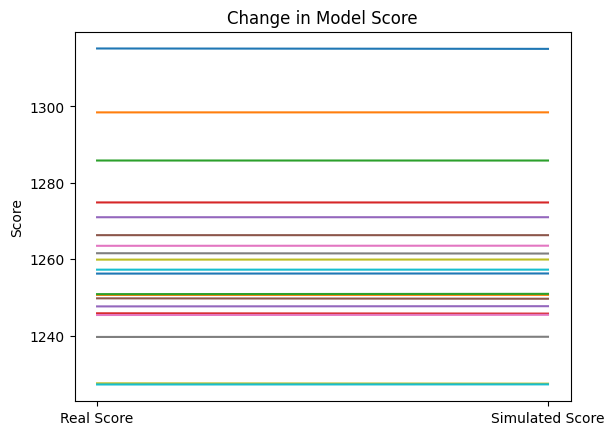

In [128]:
score_sim = get_stats_score(replay_score, real)

fig,ax = plt.subplots(1)

ax.set_title("Change in Model Score")
ax.set_ylabel("Score")
ax.plot([score_sim['real_score'], score_sim['mean_score']])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Real Score", "Simulated Score"])

plt.show()